In [1]:
import numpy as np
import math
import cv2
import robosuite as suite
from robosuite.wrappers import GymWrapper
from mujoco_py import load_model_from_path, MjSim, MjViewer, MjRenderContextOffscreen, MjRenderContext
from dexnet import DexNet
from ik_controller import robosuite_IKmover
import robosuite.utils.transform_utils as T
from robosuite.environments import SawyerLift_vj
import matplotlib.pyplot as plt
from RRT_Planner import RRTplanner

/home/vj-viswanath/mujoco-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/vj-viswanath/mujoco-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/vj-viswanath/mujoco-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/vj-viswanath/mujoco-env/lib/python3.7/site-packages/ten

In [2]:
def set_camera_birdview(viewer, origin, distance=0.8, h =0.8):
    '''
    world.mujoco_arena.bin_abs => the center of the table is (0.6, -0.15, 0.8)
    the camera is positioned directly on top of the table looking downward, with camera calibration:
    - with default fov: 45
    [[544.40515832   0.         258.        ]
     [  0.         544.40515832 193.        ]
     [  0.           0.           1.        ]]
    the camera position in the world coordinate is:
    T: [0.6, -0.15, 0.8 + 0.9 (distance)]
    took the front view camera and rotate around y-axis:
    

    looking from robot orientation with azimuth = -180, rotation around z-axis
    '''
    
    
    viewer.cam.fixedcamid = 1
    viewer.cam.distance = distance
    viewer.cam.elevation = -90
    viewer.cam.lookat[0] = origin[0]
    viewer.cam.lookat[1] = origin[1]
    viewer.cam.lookat[2] = h

In [3]:
# configuration for depth and segmask rig
top_pad, left_pad = 110, 50
width, height = 516, 386
start = np.array([-0.08166385 + np.pi, -0.80021733,  0.39712603,  1.81847624, -0.46447373,
        0.64565823,  0])

world = SawyerLift_vj(
    ignore_done=True,
    gripper_type="TwoFingerGripper",
    use_camera_obs=False,
    has_offscreen_renderer=False,
    has_renderer=True,
    camera_name=None,
    control_freq=100)

origin = [0.16 + world.table_full_size[0] / 2, 0, 0]
print("arena origin:", origin)
world.reset()
world.set_robot_joint_positions(start)
ik_wrapper = robosuite_IKmover(world)
world.render()
world.mode = 'human'
sim = world.sim

viewer = MjRenderContextOffscreen(sim, 0)

Creating window glfw
arena origin: [0.56, 0, 0]
Creating window glfw
Creating window glfw


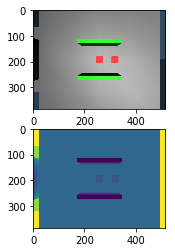

(386, 516)
0.9668721 pos: 113 171 max: 0.98686886 pos: 0 0 box depth: 0.97213435


In [4]:
set_camera_birdview(viewer, origin, distance=0.8, h=0.8)
viewer.render(width, height)
image = np.asarray(viewer.read_pixels(width, height, depth=False)[:, :, :], dtype=np.uint8)
depth = np.asarray((viewer.read_pixels(width, height, depth=True)[1]))    
# , depth[left_pad, top_pad], depth[-left_pad, -top_pad]

plt.figure()
plt.subplot(2,1,1)
plt.imshow(image)

plt.subplot(2,1,2)
plt.imshow(depth)
plt.show()
print(depth.shape)
print(np.min(depth), "pos:", int(np.argmin(depth)/len(depth[0])), np.argmin(depth)%len(depth[0]),\
      "max:", np.max(depth), "pos:", int(np.argmax(depth)/len(depth[0])), np.argmax(depth)%len(depth[0]),\
     "box depth:", depth[193,258])
# min depth is wall

In [5]:
# cdepth = np.min(depth)

# seg = depth <= cdepth

# cv2.imwrite('./seg_mask2.png', seg*255)

In [6]:
cdepth = depth[50,50]

depth[depth > cdepth] = cdepth
seg = depth != cdepth
offset, scale = np.min(depth), np.max(depth) - np.min(depth)
depth = (depth - np.min(depth)) / (np.max(depth) - np.min(depth))

# seg[:, :top_pad], seg[:, -top_pad:] = False, False
# seg[:left_pad, :], seg[-left_pad:, :] = False, False
# seg = cv2.imread('./seg_mask.png',cv2.IMREAD_GRAYSCALE) > 128


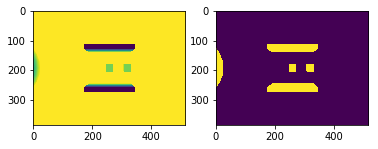

In [7]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(depth)
plt.subplot(1,2,2)
plt.imshow(seg)
plt.show()

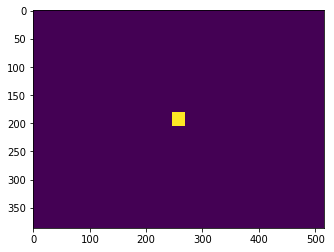

In [8]:
seg[:150,:] = False
seg[225:,:] = False
seg[:,:100] = False
seg[:,300:] = False
plt.imshow(seg)
plt.show()

In [9]:

dexnet = DexNet()
dexnet.prepare_dexnet()
print("dexnet prepared")
state, rgbd_im = dexnet.get_state(depth, seg)
action = dexnet.get_action(state)

GQCNNModelFactory INFO     Initializing GQ-CNN with Tensorflow as backend...
tensorflow WARNING  From /home/vj-viswanath/mujoco-env/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
GQCNNTF    INFO     Building Network...
GQCNNTF    INFO     Building Image Stream...
GQCNNTF    INFO     Building convolutional layer: conv1_1...
GQCNNTF    INFO     Building convolutional layer: conv1_2...
GQCNNTF    INFO     Building convolutional layer: conv2_1...
GQCNNTF    INFO     Building convolutional layer: conv2_2...
GQCNNTF    INFO     Building fully connected layer: fc3...
tensorflow WARNING  From /home/vj-viswanath/gqcnn_michael/dexnet_robosuite/gqcnn/model/tf/network_tf.py:1143: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a futur

center: 262.0, 187.0
depth: 0.8308304301184392
rot: [[ 0.         -0.00414198  0.99999142]
 [ 0.         -0.99999142 -0.00414198]
 [ 1.          0.          0.        ]]
tra: [ 0.00977448 -0.00714289  0.83083043]
camera intr: ['K', '_K', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_cx', '_cy', '_frame', '_fx', '_fy', '_height', '_skew', '_width', 'crop', 'cx', 'cy', 'deproject', 'deproject_pixel', 'deproject_to_image', 'frame', 'from_vec', 'fx', 'fy', 'height', 'load', 'proj_matrix', 'project', 'project_to_image', 'resize', 'rosmsg', 'save', 'skew', 'vec', 'width']
proj matrix: [[552.5    0.   255.5 ]
 [  0.   552.5  191.75]
 [  0.     0.     1.  ]]
other attr: ['__class__', '__delattr__', 

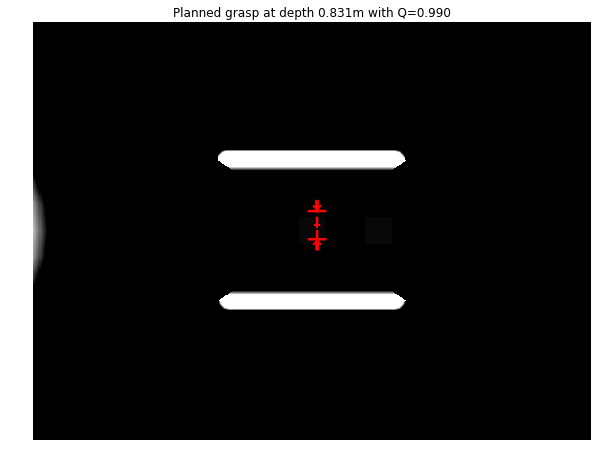

In [68]:
'''
get depth of the action and the x, y
apply inverse from camera coordinate to the world coordinate
'''
dexnet.visualization(action, rgbd_im, offset, scale)

action.grasp.depth = action.grasp.depth * scale + offset
rigid_transform = action.grasp.pose()
print('center: {}, {}'.format(action.grasp.center.x, action.grasp.center.y))
print('depth: {}'.format(action.grasp.depth))
print('rot: {}'.format(rigid_transform.rotation))
print('tra: {}'.format(rigid_transform.translation))
print('camera intr: {}'.format(dir(action.grasp.camera_intr)))
print('proj matrix: {}'.format(action.grasp.camera_intr.proj_matrix))
print('other attr: {}'.format(dir(action.grasp)))

In [69]:
gripper_pos = rigid_transform.translation.flatten() + np.array([0.56, 0, -0.01])


theta = action.grasp.angle

R = np.array([[np.cos(theta),  -np.sin(theta),  0.0000000],
              [np.sin(theta),  np.cos(theta),  0.0000000],
              [0.0000000, 0.0000000,  1.0000000 ]])
I = np.array([[1, 0, 0],
              [0, -1, 0],
              [0, 0, -1]])
gripper_rotation_m = R@I

print('gripper position: {}'.format(gripper_pos))

gripper position: [ 0.56977448 -0.00714289  0.82083043]


In [70]:
T.mat2quat(gripper_rotation_m)

array([-0.70564085,  0.70856968,  0.        ,  0.        ])

In [71]:
def sawyer_set_joints_fn(env, state):
    env.set_robot_joint_positions(state)

def sawyer_set_velocities(env, velocity):
    index = 0
    for i in env._ref_joint_vel_indexes:
        env.sim.data.qvel[i] = velocity[index]
        index += 1

def sawyer_get_action_fn(env, w_cur,w_next):
    w_direction = (w_next-w_cur + np.pi) % (2*np.pi) - np.pi
    # Use a PID controller
    k = np.ones([len(w_direction)])* 0.1
    v = env._get_observation()['joint_vel']
    k_d = np.ones([len(w_direction)])* 0.1
    return np.concatenate( (k*w_direction-k_d*v,[0]) )

def sawyer_collision_fn(env):
    sim = env.sim
    for contact in sim.data.contact[: env.sim.data.ncon]:
        if sim.model.geom_id2name(contact.geom1) is None or sim.model.geom_id2name(contact.geom2) is None:
            return True
        if ( sim.model.geom_id2name(contact.geom1) in env.gripper.contact_geoms() or
            sim.model.geom_id2name(contact.geom2) in env.gripper.contact_geoms() ):
            return True
    return False

def sawyer_obs_fn(env):
    return env._joint_positions

def sawyer_xyz_obs_fn(env):
    obs = env._get_observation()
    return np.concatenate((obs['eef_pos'], obs['eef_quat']))

def sawyer_dist_fn(w1,w2):
    d = (w2-w1 + np.pi) % (2*np.pi) - np.pi
    return np.linalg.norm(d)

sawyer_d_thres = np.pi/2
sawyer_min_dist = np.pi/15
sawyer_coll_dist = np.pi/15
sawyer_box_granularity = np.pi/4
sawyer_start = np.array([-0.08166385, -0.80021733,  0.39712603,  1.81847624, -0.46447373,
        0.64565823,  0])
sawyer_bbox_start = np.zeros([7])
sawyer_bbox_start[0] = -np.pi/4
sawyer_bbox_start[1] = -3*np.pi/4
sawyer_bbox_start[2] = -np.pi/2
sawyer_bbox_start[3] = -np.pi/2
sawyer_bbox_start[4] = -np.pi/4
sawyer_bbox_start[5] = -np.pi/4
sawyer_bbox_start[6] = 0
sawyer_bbox_end = np.zeros([7])
sawyer_bbox_end[0] = np.pi/4
sawyer_bbox_end[1] = np.pi/2
sawyer_bbox_end[2] = np.pi/2
sawyer_bbox_end[3] = np.pi/2
sawyer_bbox_end[4] = np.pi/4
sawyer_bbox_end[5] = np.pi/4
sawyer_bbox_end[6] = 0

sawyer_rrt= RRTplanner(env=world, set_joints_fn=sawyer_set_joints_fn, set_velocity=sawyer_set_velocities, get_action_fn=sawyer_get_action_fn,\
                       collision_fn=sawyer_collision_fn, obs_fn=sawyer_obs_fn, xyz_obs_fn=sawyer_xyz_obs_fn,\
                       dist_fn=sawyer_dist_fn, d_thres=sawyer_d_thres, min_dist=sawyer_min_dist, coll_dist = sawyer_coll_dist,\
                       box_granularity=sawyer_box_granularity, start=sawyer_start, \
                       bbox_start=sawyer_bbox_start, bbox_end=sawyer_bbox_end)

Creating window glfw


In [72]:
filename='./sawyer_planner_data1.pkl'
sawyer_rrt.load_planner(filename)

In [75]:
start = np.array([-0.08166385 , -0.80021733,  0.39712603,  1.81847624, -0.46447373,
        0.64565823,  0])
world.set_robot_joint_positions(start)
initial_pos = np.copy(world.observation_spec()['eef_pos'])

min_d = np.inf
nearest_point = None
for xyz in sawyer_rrt.xyz_to_nodes:
    d = np.linalg.norm(xyz[:3]-gripper_pos[:3])
    if (d < min_d):
        min_d = d
        nearest_point = xyz

# Now that we have nearest point, find a path to the nearest point
w_xyz = sawyer_rrt.xyz_to_nodes[nearest_point][0]
path = [w_xyz]
while sawyer_rrt.nodes_parent[tuple(w_xyz)] is not None:
    path.append(sawyer_rrt.nodes_parent[tuple(w_xyz)])
    w_xyz = sawyer_rrt.nodes_parent[tuple(w_xyz)]
print('nearest point:',nearest_point, '\n the joint angles:', sawyer_rrt.xyz_to_nodes[nearest_point][0])
print(len(path))

nearest point: (0.6600170868188664, 0.011332046767501262, 0.9897362085337936, 0.7851206508500039, -0.4941109082783307, 0.32908275442643764, 0.17647808551867938) 
 the joint angles: [ 4.58473512e-01 -4.40050487e-01 -7.58998986e-01  1.45143745e+00
 -1.06466530e-01  3.95645207e-01  4.12021172e-04]
13


In [77]:
sawyer_rrt.env.reset()
# self.env.viewer.set_camera(camera_id=2)
sawyer_rrt.set_joints_fn(sawyer_rrt.env, sawyer_rrt.start)
sawyer_rrt.env.render()
x_current = sawyer_rrt.start
lamda = 1
for i in range(1, len(path)):
    x_next = path[-i]
#     print("moving to:",x_next)
    steps = 0
    while (sawyer_rrt.dist_fn(x_next, x_current) > 0.01):
        action = sawyer_rrt.get_action_fn(env=sawyer_rrt.env, w_cur= x_current, w_next=x_next)
        sawyer_rrt.env.step(action*lamda)
        lamda = 1 + np.min((0.001*steps, 2))
        steps +=1
        x_current = sawyer_rrt.obs_fn(sawyer_rrt.env)
        sawyer_rrt.env.render()

x_next = path[0]

steps = 0
while (sawyer_rrt.dist_fn(x_next, x_current) > 0.0001):
    action = sawyer_rrt.get_action_fn(env=sawyer_rrt.env, w_cur= x_current, w_next=x_next)
    sawyer_rrt.env.step(action*lamda)
    if (sawyer_rrt.dist_fn(x_next, x_current) < 0.01):
        lamda = lamda*1.01
    else :
        lamda = 1
    steps +=1
    x_current = sawyer_rrt.obs_fn(sawyer_rrt.env)
    sawyer_rrt.env.render()
    if (steps > 200):
        break
### Now use IK controller to move to object position

from ik_controller import robosuite_IKmover
import robosuite.utils.transform_utils as T
ik_wrapper = robosuite_IKmover(world)
        
# gripper_pos = target_position[:3]
# gripper_quat = target_position[3:]
# gripper_rotation_m = T.quat2mat(gripper_quat)
# gripper_rotation_m = rigid_transform.rotation

# gripper_rotation_m = T.quat2mat([-2.37649383e-04, -9.99999946e-01,  2.14259657e-04, -7.87877081e-05])
# theta = action.grasp.angle

# R = np.array([[np.cos(theta),  -np.sin(theta),  0.0000000],
#               [np.sin(theta),  np.cos(theta),  0.0000000],
#               [0.0000000, 0.0000000,  1.0000000 ]])
# I = np.array([[1, 0, 0],
#               [0, -1, 0],
#               [0, 0, -1]])
# gripper_rotation_m = R@I

initial_pos = np.copy(world.observation_spec()['eef_pos'])

ik_wrapper.move(gripper_pos, gripper_rotation_m)
ik_wrapper.lift(initial_pos)

Creating window glfw
Lifting
